In [1]:
%run Helper.ipynb

Num GPUs Available:  1


In [2]:
# Load all images
IMAGES = load_images()

MemoryError: 

In [ ]:
# Load model
set_legacy(False)
MODEL = load_model(MODEL_HANDLE)

In [ ]:
# Setup detections (which can be used to generate statistics later)
IMAGES_WITH_DETECTION = run_inference(IMAGES, MODEL)

In [5]:
# Setup detected classes with count and two array for confidence scores and bounding boxes
DETECTED_CLASSES = get_detections_for_images(IMAGES_WITH_DETECTION)

In [8]:
# Draw detections on images
draw_detections_on_images(IMAGES_WITH_DETECTION)

In [ ]:
# Save new images
save_images(IMAGES_WITH_DETECTION, MODEL_NAME, single=True)

Average detections per image: 4.22


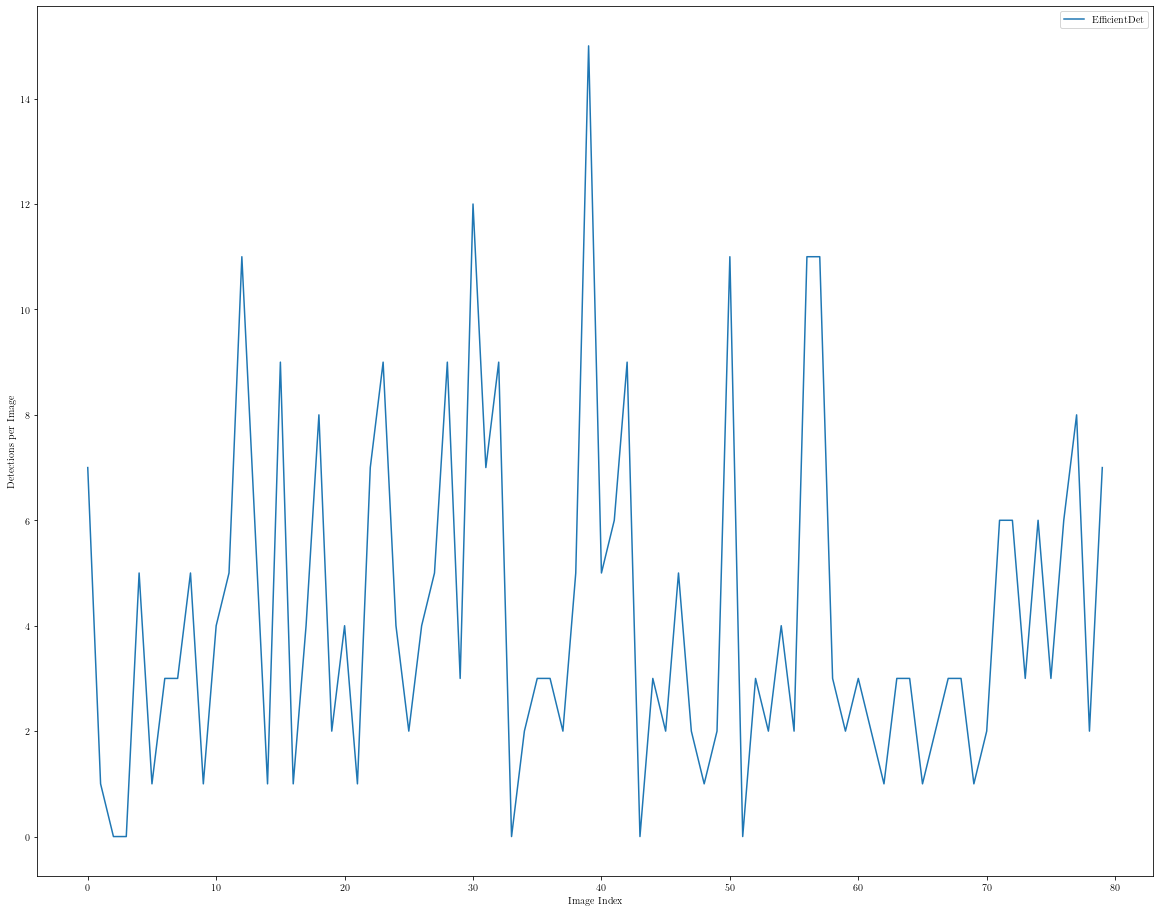

In [17]:
# Generate statistics
get_statistics_for_detections(DETECTED_CLASSES, len(IMAGES), single=True)
generate_detection_chart(DETECTED_CLASSES, len(IMAGES))

In [22]:
DETECTION_LABELS = get_detected_labels(DETECTED_CLASSES)

In [126]:
# Get babelnet entities for detected labels
get_entity_mapping(DETECTION_LABELS)
save_entity_mapping(DETECTION_LABELS, 'outputs/statistics/mapped_entities.csv')

Label: Chair
{'type': 'BabelSense', 'properties': {'fullLemma': 'chair', 'simpleLemma': 'chair', 'lemma': {'lemma': 'chair', 'type': 'HIGH_QUALITY'}, 'source': 'WIKIDATA', 'senseKey': 'Q15026', 'frequency': 0, 'language': 'EN', 'pos': 'NOUN', 'synsetID': {'id': 'bn:00017515n', 'pos': 'NOUN', 'source': 'BABELNET'}, 'translationInfo': '', 'pronunciations': {'audios': [{'lemma': 'chair', 'language': 'EN', 'filename': 'en-us-chair.ogg'}], 'transcriptions': ['/t͡ʃɛə(ɹ)/', '/t͡ʃɛəɹ/']}, 'bKeySense': True, 'idSense': 494349147, 'tags': {}}}
Label: Person
{'type': 'BabelSense', 'properties': {'fullLemma': 'person', 'simpleLemma': 'person', 'lemma': {'lemma': 'person', 'type': 'HIGH_QUALITY'}, 'source': 'WIKIDATA', 'senseKey': 'Q215627', 'frequency': 0, 'language': 'EN', 'pos': 'NOUN', 'synsetID': {'id': 'bn:00046516n', 'pos': 'NOUN', 'source': 'BABELNET'}, 'translationInfo': '', 'pronunciations': {'audios': [], 'transcriptions': ['/ˈpɝsən/', '[ˈpʰɜːsn̩]', '[ˈpʰɚsn̩]', '/ˈpɜːsən/']}, 'bKeySense

{'type': 'BabelSense', 'properties': {'fullLemma': 'bed', 'simpleLemma': 'bed', 'lemma': {'lemma': 'bed', 'type': 'HIGH_QUALITY'}, 'source': 'WIKIDATA', 'senseKey': 'Q42177', 'frequency': 0, 'language': 'EN', 'pos': 'NOUN', 'synsetID': {'id': 'bn:00009472n', 'pos': 'NOUN', 'source': 'BABELNET'}, 'translationInfo': '', 'pronunciations': {'audios': [{'lemma': 'bed', 'language': 'EN', 'filename': 'En-uk-bed.ogg'}], 'transcriptions': ['/bɛd/', '/bed/', '[beː]']}, 'bKeySense': True, 'idSense': 492434192, 'tags': {}}}
Label: Bear
{'type': 'BabelSense', 'properties': {'fullLemma': 'bear', 'simpleLemma': 'bear', 'lemma': {'lemma': 'bear', 'type': 'HIGH_QUALITY'}, 'source': 'WIKIDATA', 'senseKey': 'Q1019010', 'frequency': 0, 'language': 'EN', 'pos': 'NOUN', 'synsetID': {'id': 'bn:01018843n', 'pos': 'NOUN', 'source': 'BABELNET'}, 'translationInfo': '', 'pronunciations': {'audios': [], 'transcriptions': ['/bɛəɹ/', '/bɛə(ɹ)/', '/bɛː(ɹ)/', '/bɑɹ/']}, 'bKeySense': False, 'idSense': 509472357, 'tags'

In [70]:
# Generate RDF information from object detection
from rdflib import Graph, Literal, RDF, URIRef, Namespace, BNode
from rdflib.namespace import FOAF, OWL, RDFS, XSD, SKOS, DCTERMS
from uuid import uuid4
from datetime import datetime

# Generate uri by urlencoding the filename and prepending a namespace, if given
def generate_uri(filename, namespace=''):
    return URIRef(namespace + parse.quote_plus(filename))

# Remove file extension from given filename, extension defaults to .jpg
def remove_file_extension(filename, extension='.jpg'):
    i = filename.find(extension);
    
    if i != -1:
        return filename[:i]
    else:
        return filename
    
# Get the url of the mapped wikidata entity as a string (if a mapping exists), returns empty string otherwise
def get_mapped_entity(label):
    mapped = [detection for detection in DETECTION_LABELS if detection['class'] == label.capitalize()]
    
    if len(mapped) > 0 and mapped[0]['wikidata'] != 'No match':
        return mapped[0]['wikidata']
    else:
        return ''

# Create graph and add namespaces
g = Graph()

OA = Namespace('http://www.w3.org/ns/oa#')
g.namespace_manager.bind('oa', OA)
SLOD = Namespace('http://slod.fiz-karlsruhe.de/')
g.namespace_manager.bind('slod', SLOD)
NIF = Namespace('http://persistence.uni-leipzig.org/nlp2rdf/ontologies/nif-core')
g.namespace_manager.bind('nif', NIF)
g.namespace_manager.bind('dcterms', DCTERMS)

# Generate date of creation
current_date = datetime.now().strftime('%Y-%m-%dT%H:%M:%SZ')

for filename in list(DETECTED_CLASSES.keys())[:1]:
    imageURI = generate_uri(remove_file_extension(filename), SLOD.images + '/')
    no_extension = remove_file_extension(filename)

    # Required to keep indices for a single image unique in the graph
    offset = 1
    # For each detected class on the image
    for label, detection in DETECTED_CLASSES[filename].items():
        # For each bounding box that exists of the current class in the current image
        for index, box in enumerate(detection['boxes']):
            # Create two blank nodes for target and selector
            blank_node_target = BNode(generate_uri('target-' + no_extension + '-' + str(offset)))
            blank_node_selector = BNode(generate_uri('selector-' + no_extension + '-' + str(offset)))
            
            # Add source for current annotation
            g.add((blank_node_target, OA.hasSource, imageURI))
            
            # Add annotation
            annotationURI = generate_uri(no_extension + '-' + str(offset), SLOD.annotation + '/')
            g.add((annotationURI, OA.hasTarget, blank_node_target))
            g.add((annotationURI, RDF.type, OA.Annotation))
            g.add((annotationURI, DCTERMS.creator, SLOD.ObjectDetector))
            g.add((annotationURI, NIF.confidence, Literal(detection['scores'][index], datatype=XSD.float)))
            g.add((annotationURI, RDFS.label, Literal(label.capitalize(), lang='en')))
            g.add((annotationURI, DCTERMS.created, Literal(current_date, datatype=XSD.dateTime)))
            
            # Add wikidata mapping if existent
            mapped = get_mapped_entity(label)
            if mapped:
                g.add((annotationURI, OA.hasBody, generate_uri(mapped)))
                
            # Add Selector
            g.add((blank_node_target, OA.hasSelector, blank_node_selector))
            g.add((blank_node_selector, RDF.value, Literal('xywh=' + str(box[1]) + ',' + str(box[0]) + ',' + str(box[3]-box[1]) + ',' + str(box[2]-box[0]), datatype=XSD.string)))
            g.add((blank_node_selector, RDF.type, OA.FragmentSelector))
            g.add((blank_node_selector, DCTERMS.conformsTo, URIRef('http://www.w3.org/TR/media-frags/')))
            
            # Increase offset
            offset += 1
            
print(g.serialize(format='n3'))

@prefix dcterms: <http://purl.org/dc/terms/> .
@prefix nif: <http://persistence.uni-leipzig.org/nlp2rdf/ontologies/nif-core> .
@prefix oa: <http://www.w3.org/ns/oa#> .
@prefix rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#> .
@prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#> .
@prefix slod: <http://slod.fiz-karlsruhe.de/> .
@prefix xsd: <http://www.w3.org/2001/XMLSchema#> .

<http://slod.fiz-karlsruhe.de/annotation/E+18+III_Nr+1+Bild+0001+%5Baid+2-2061432-1%5D-1> a oa:Annotation ;
    rdfs:label "Chair"@en ;
    nif:confidence "0.82271713"^^xsd:float ;
    dcterms:created "2021-09-27T14:32:56+00:00"^^xsd:dateTime ;
    dcterms:creator slod:ObjectDetector ;
    oa:hasBody <http%3A%2F%2Fwww.wikidata.org%2Fwiki%2FQ15026> ;
    oa:hasTarget [ oa:hasSelector [ a oa:FragmentSelector ;
                    dcterms:conformsTo <http://www.w3.org/TR/media-frags/> ;
                    rdf:value "xywh=0.1662294,0.73464864,0.07113212,0.14741307"^^xsd:string ] ;
            oa:hasSource <http